# Project 1: High School Social Network Analysis

##### Jimmy Ng & Corey Arnouts

## Overview

For this project, we are going to look at the interactions between students at a high school in France. This dataset includes categorical data about the genders of the students. The data is extracted from the website **sociopatterns.org**.

http://www.sociopatterns.org/datasets/high-school-dynamic-contact-networks/

## Import data

In [229]:
import networkx as nx
from nxviz import CircosPlot
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
import warnings

warnings.filterwarnings('ignore')

df2011 = pd.read_csv('https://raw.githubusercontent.com/myvioletrose/data620_team/master/assignment/week_4/high-school-social-network2011.txt',
                 sep='\t',
                 header=None,
                 names=['t', 'i', 'j','Ci','Cj'])

attributes2011 = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2011.txt',
                  sep='\t',
                  header=None,
                  names=['node', 'dept','gender'])


## Plan for analysis

First, we simplify the dataset by summing up the frequency of communication between students. We will use it ('freq') as 'weight'. We generate our edge and node sets for building an **undirected** graph. Subsequently, we will visualize the overall social network before moving on to calculate **neighbors** and different **centrality** meausures. We will compare the differences between male and female. In addition, we will find and return all possible **cliques** in this exercise. Lastly, we will visualize the shortest path between the most and least popular students.

## Edge, Node Sets

In [230]:
# edge2011
edge2011 = df2011.loc[:,'t':'j'].groupby(['i', 'j']).count().reset_index()
edge2011.columns = ['student_id1', 'student_id2', 'freq']

node2011 = attributes2011.loc[:, ['node', 'gender']]

node2011['gender'] = node2011.gender.astype(str)

In [231]:
edge2011

,student_id1,student_id2,freq
0,1,2,5
1,1,3,7
2,1,4,1
3,1,6,2
4,1,8,1
5,1,11,20
6,1,12,15
7,1,16,3
8,1,17,1
9,1,30,3


In [232]:
node2011

,node,gender
0,28,F
1,103,F
2,34,M
3,81,M
4,56,F
5,93,M
6,106,F
7,24,M
8,23,M
9,26,M


In [233]:
edge2011.shape

(1710, 3)

In [234]:
node2011.shape

(126, 2)

## Undirected Graph

In [235]:
# undirected graph
undirected_G = nx.Graph()

# adding edges to graph 
for idx in edge2011.index:    
    p1 = edge2011.loc[idx]['student_id1'].item()
    p2 = edge2011.loc[idx]['student_id2'].item()
    w = edge2011.loc[idx]['freq'].item()
    undirected_G.add_edge(p1, p2, weight = w)    

# add node attribute
for node in undirected_G.nodes:    
    undirected_G.node[node]['gender'] = node2011.loc[node2011['node'] == node, 'gender'].item()

In [236]:
list(undirected_G.nodes(data = True))[:5]

[(1, {'gender': 'M'}),
 (2, {'gender': 'M'}),
 (3, {'gender': 'M'}),
 (4, {'gender': 'M'}),
 (6, {'gender': 'M'})]

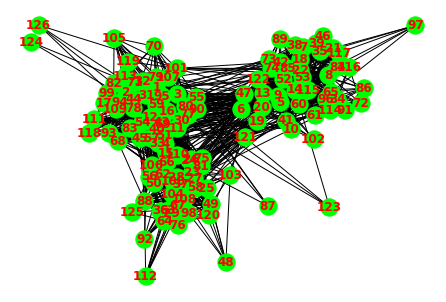

In [237]:
nx.draw(undirected_G, with_labels = True, font_weight = 'bold', node_color = "lime", font_color = "red")    

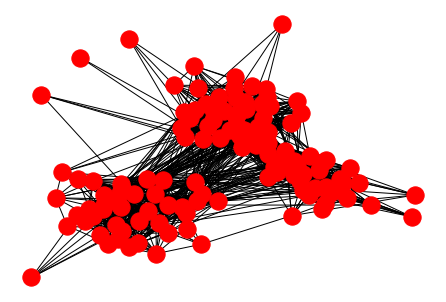

In [238]:
nx.draw(undirected_G)    

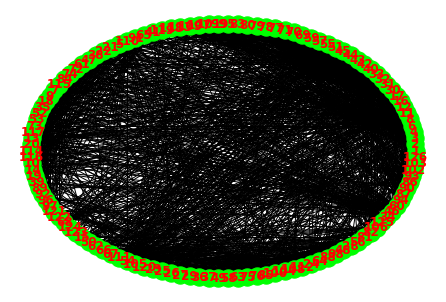

In [239]:
nx.draw_shell(undirected_G, with_labels = True, font_weight = 'bold', node_color = "lime", font_color = "red")    

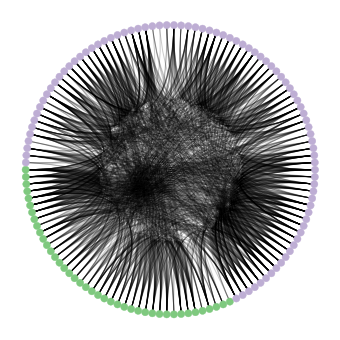

In [240]:
c = CircosPlot(undirected_G, node_color = 'gender', node_grouping = 'gender')
c.draw()

## Neighbors

Counting a number of neighbors (nodes) associated with a node is an important first step to evaluate its significance in a graph. We can consider it as a popularity measure for each student. 

In [241]:
node_to_neighbors_mapping = [(node, len(list(undirected_G.neighbors(node)))) for node in undirected_G.nodes()]

node_to_neighbors_ser = pd.Series(data = dict(node_to_neighbors_mapping))

node_to_neighbors_ser.sort_values(ascending = False).head()

16    55
11    54
43    52
51    51
69    50
dtype: int64

In [242]:
n = node_to_neighbors_ser.sort_values(ascending = False).to_frame()
n.reset_index(inplace = True)
n.columns = ['node', 'neighbors']

In [243]:
most_popular_student = n.head(1).iloc[0,0]
least_popular_student = n.tail(1).iloc[0,0]
print(f'The most popular student in school in terms of number of connection is student \'{most_popular_student}\', whereas the least popular student is \'{least_popular_student}\'')

The most popular student in school in terms of number of connection is student '16', whereas the least popular student is '124'


In [244]:
node2011 = node2011.merge(n, on = 'node').sort_values(by = ['neighbors'], ascending = False)

In [245]:
node2011.groupby('gender')['neighbors'].mean()

gender
F    24.707317
M    28.305882
Name: neighbors, dtype: float64

## Degree Centrality 

In [246]:
sorted(nx.degree_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(16, 0.44), (11, 0.432), (43, 0.424), (51, 0.40800000000000003), (69, 0.4)]

In [247]:
d = pd.DataFrame.from_dict(nx.degree_centrality(undirected_G), 
                           orient = 'index')
d.reset_index(inplace = True)
d.columns = ['node', 'degree_centrality']

In [248]:
node2011 = node2011.merge(d, on = 'node')

In [249]:
node2011.groupby('gender')['degree_centrality'].mean()

gender
F    0.197659
M    0.226541
Name: degree_centrality, dtype: float64

## Eigenvector Centrality

In [250]:
sorted(nx.eigenvector_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(11, 0.18500163165627898),
 (16, 0.17985831053759269),
 (43, 0.17684535354313194),
 (51, 0.17369312502951845),
 (69, 0.17075978028219066)]

In [251]:
e = pd.DataFrame.from_dict(nx.eigenvector_centrality(undirected_G),                            
                           orient = 'index')
e.reset_index(inplace = True)
e.columns = ['node', 'eigenvector_centrality']

In [191]:
node2011 = node2011.merge(e, on = 'node')

In [192]:
node2011.groupby('gender')['eigenvector_centrality'].mean()

gender
F    0.069568
M    0.078387
Name: eigenvector_centrality, dtype: float64

## Betweenness Centrality

In [193]:
sorted(nx.betweenness_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(9, 0.05159759192933358),
 (6, 0.038182961081232876),
 (13, 0.033807244987578054),
 (80, 0.03205582247470008),
 (43, 0.02830540297613953)]

In [194]:
b = pd.DataFrame.from_dict(nx.eigenvector_centrality(undirected_G),                            
                           orient = 'index')
b.reset_index(inplace = True)
b.columns = ['node', 'betweenness_centrality']

In [195]:
node2011 = node2011.merge(b, on = 'node')

In [196]:
node2011.groupby('gender')['betweenness_centrality'].mean()

gender
F    0.069568
M    0.078387
Name: betweenness_centrality, dtype: float64

## Node Table Summary

In this exercise, there is no considerable difference between genders from the above measures. 

In [197]:
node2011.sort_values(by = ['neighbors'], ascending = False)

,node,gender,neighbors,degree_centrality,eigenvector_centrality,betweenness_centrality
0,16,M,55,0.440,0.179858,0.179858
1,11,F,54,0.432,0.185002,0.185002
2,43,M,52,0.424,0.176845,0.176845
3,51,F,51,0.408,0.173693,0.173693
4,9,M,50,0.400,0.092180,0.092180
5,69,M,50,0.400,0.170760,0.170760
6,12,M,48,0.384,0.169270,0.169270
7,24,M,47,0.376,0.137567,0.137567
8,40,F,47,0.376,0.170624,0.170624
9,13,M,46,0.368,0.114127,0.114127


## Cliques

Let's look at number and size of cliques formed in this high school network.

In [198]:
cliques = list(nx.find_cliques(undirected_G))
print('there is {x} number of cliques in this network'.format(x = len(cliques)))

there is 1314 number of cliques in this network


In [199]:
cliques

[[4, 56, 106, 40, 24, 81],
 [4, 56, 106, 40, 24, 45],
 [4, 56, 106, 40, 54, 45],
 [4, 56, 106, 67, 24, 81],
 [4, 67, 26, 69, 37, 81, 24, 57, 106],
 [4, 67, 26, 69, 37, 81, 24, 27],
 [4, 11, 40, 107, 101, 12, 44, 77, 78, 1, 80, 3],
 [4, 11, 40, 107, 101, 12, 44, 77, 78, 1, 45],
 [4, 11, 40, 107, 101, 12, 44, 77, 78, 54, 3],
 [4, 11, 40, 107, 101, 12, 44, 77, 78, 54, 45],
 [4, 11, 40, 44, 12, 78, 59, 1, 33, 57, 45, 30],
 [4, 11, 40, 44, 12, 78, 59, 1, 101, 57, 45, 30],
 [4, 11, 40, 44, 12, 78, 59, 1, 101, 77, 80, 3],
 [4, 11, 40, 44, 12, 78, 59, 1, 101, 77, 80, 30],
 [4, 11, 40, 44, 12, 78, 59, 1, 101, 77, 45, 30],
 [4, 11, 40, 44, 12, 78, 59, 54, 33, 57, 45, 30],
 [4, 11, 40, 44, 12, 78, 59, 54, 101, 57, 45, 30],
 [4, 11, 40, 44, 12, 78, 59, 54, 101, 77, 3],
 [4, 11, 40, 44, 12, 78, 59, 54, 101, 77, 45, 30],
 [4, 11, 40, 69, 81, 33, 24, 57, 106, 26],
 [4, 11, 40, 69, 81, 33, 24, 57, 13],
 [4, 11, 40, 69, 81, 33, 19, 26],
 [4, 11, 40, 69, 81, 33, 19, 13],
 [4, 11, 40, 69, 19, 33, 45, 30]

In [200]:
x = [len(clique) for clique in cliques]
counter = collections.Counter(x)

In [201]:
c = pd.DataFrame.from_dict(counter, orient = 'index')
c.reset_index(inplace = True)
c.columns = ['size_of_clique', 'num_of_clique']

In [202]:
c.sort_values(by = ['num_of_clique'], ascending = False)

,size_of_clique,num_of_clique
1,9,186
2,8,166
3,12,136
7,7,102
12,14,98
6,5,96
5,10,95
0,6,92
13,15,82
8,4,78


In [203]:
most_common_size_of_clique = [i[0] for i in counter.most_common(1)][0]
largest_num_of_clique = [i[1] for i in counter.most_common(1)][0]

In [204]:
print(f'The most common size of clique is {most_common_size_of_clique}, i.e. it implies that {most_common_size_of_clique} is an optimal number of forming an inner circle')
print(f'We have {largest_num_of_clique} cliques that is the size of {most_common_size_of_clique} in this network')

The most common size of clique is 9, i.e. it implies that 9 is an optimal number of forming an inner circle
We have 186 cliques that is the size of 9 in this network


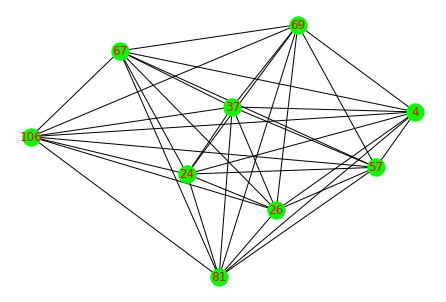

In [205]:
# draw a sample of the most common clique
most_common_clique = [clique for clique in cliques if len(clique) == most_common_size_of_clique]
nx.draw(undirected_G.subgraph(most_common_clique[0]), with_labels = True, node_color = "lime", font_color = "red")

## Most Popular Person

this person is in 425 number of clique, and here is a sample of his connections


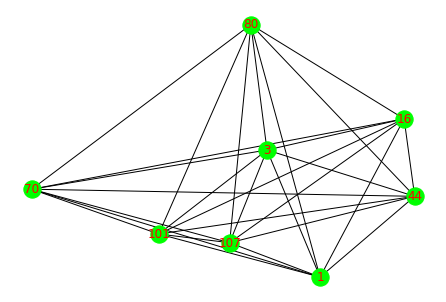

In [206]:
# draw a sample of network for the most popular person
most_popular_person = [clique for clique in cliques if most_popular_student in clique]
print('this person is in {x} number of clique, and here is a sample of his connections'.format(x = len(most_popular_person)))

nx.draw(undirected_G.subgraph(most_popular_person[0]), with_labels = True, node_color = "lime", font_color = "red")

## Shortest Path between the Most and Least Popular Persons

[16, 11, 124]


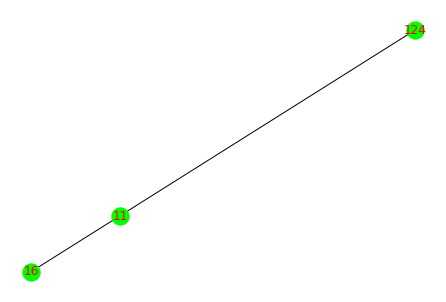

In [207]:
shortest_path = nx.shortest_path(undirected_G, most_popular_student, least_popular_student)

print(shortest_path)

nx.draw(undirected_G.subgraph(shortest_path), with_labels = True, node_color = "lime", font_color = "red")


## Trying out the Pyvis Package


In [254]:
from pyvis import network as net 
df2011 = pd.read_csv('https://raw.githubusercontent.com/myvioletrose/data620_team/master/assignment/week_4/high-school-social-network2011.txt',
                 sep='\t',
                 header=None,
                 names=['t', 'i', 'j','Ci','Cj'])

attributes2011 = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2011.txt',
                  sep='\t',
                  header=None,
                  names=['node', 'dept','gender'])


# edge2011
edge2011 = df2011.loc[:,'t':'j'].groupby(['i', 'j']).count().reset_index()
edge2011.columns = ['student_id1', 'student_id2', 'freq']

# node2011
node2011 = attributes2011.loc[:, ['node', 'gender','dept']]

node2011['gender'] = node2011.gender.astype(str)
node2011['dept'] = node2011.dept.astype(str)


In [255]:
from pyvis import network as net

node2011['node'] = node2011.node.astype(int)
node2011['gender'] = node2011.gender.astype(str)
node2011['dept'] = node2011.dept.astype(str)

node2011['key'] = node2011.node.astype(int)
edge2011['key'] = edge2011.student_id1.astype(int)


edge2011 = edge2011.set_index('key').join(node2011.set_index('key'))

edge2011 = edge2011.drop(columns=['node'])

edge2011['key_2'] = edge2011.student_id2.astype(int)

node2011_2 = node2011.add_suffix('_2')

edge2011 = edge2011.set_index('key_2').join(node2011_2.set_index('key_2'))

edge2011 = edge2011.drop(columns=['node_2'])

#########################################################################################
#########################################################################################
#########################################################################################

class_net = net.Network(height="750px", width="100%", bgcolor="#222222",font_color="white",notebook=True)
# set the physics layout of the network
class_net.barnes_hut()
#got_data = pd.read_csv("https://www.macalester.edu/~abeverid/data/stormofswords.csv")




edge2011['student_id1'] = edge2011.student_id1.astype(str)
edge2011['student_id2'] = edge2011.student_id2.astype(str)
edge2011['gender'] = edge2011.gender.astype(str)
edge2011['gender_2'] = edge2011.gender_2.astype(str)
edge2011['dept'] = edge2011.dept.astype(str)
edge2011['dept_2'] = edge2011.dept_2.astype(str)


sources = edge2011.iloc[:,0]
targets = edge2011.iloc[:,1]
weights = edge2011.iloc[:,2]
source_genders = edge2011.iloc[:,3]
target_genders = edge2011.iloc[:,5]
source_class = edge2011.iloc[:,4]
target_class = edge2011.iloc[:,6]
edge_data = zip(sources, targets, weights,source_genders,target_genders,source_class,target_class)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    srcgen = e[3]
    targen = e[4]
    srcclass = e[5]
    tarclass = e[6]
    
    class_net.add_node(src, src, title=src, group = (srcclass+" "+ srcgen))
    class_net.add_node(dst, dst, title=dst, group = (tarclass+" " + targen))
    class_net.add_edge(src, dst, value=w)


neighbor_map = class_net.get_adj_list()
# add neighbor data to node hover data
for node in class_net.nodes:
    node["title"] = node["group"]+ " " + node["title"] + "'s Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
class_net.show("test.html")

